In [1]:
import torch
from torch import optim
import torch.nn as nn
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import pathlib
from torch.utils import data
from siamese_dataset_example import SiamesePairDataset
import PIL.Image as Image
import matplotlib.pyplot as plt
import time
import numpy as np
import torch.nn.functional as F
import csv
import pandas
from sklearn import metrics
import itertools
from models.siamese_resnet import SiameseResnet
import log_compiler
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
import random
import PIL
from tqdm.autonotebook import tqdm
from torchvision.datasets import ImageFolder
from mediumdataset import SiameseNetworkDataset

/opt/anaconda3/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
trfm_valid = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

trfm_train = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

target_trfrm = transforms.Compose([
    lambda x: [x],
    torch.Tensor
])

### Hyper parameters
A few arbitrary predefined parameters.

In [3]:
BATCH_SIZE = 256
LEARNING_RATE = 0.003
NUM_EPOCH = 10
ARCHITECTURE = 'resnet101'
PRINT_EVERY = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Dataset

In [4]:
train_path = 'dataset/train/facescrub'
valid_path = 'dataset/valid/facescrub'

#### Siamese Network Dataset

#### Siamese Pair Dataset

In [5]:
trainset = SiamesePairDataset(root=train_path, ext='', transform=trfm_train, target_transform=target_trfrm, glob_pattern='*/*.[jJpP]*')
validset = SiamesePairDataset(root=valid_path, ext='', transform=trfm_valid, target_transform=target_trfrm, glob_pattern='*/*.[jJpP]*')
trainloader = data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = data.DataLoader(validset, batch_size=BATCH_SIZE, shuffle=True)

generating similar pair from	 dataset/train/facescrub: 100%|██████████| 98/98 [00:01<00:00, 73.34it/s]
generating different pair from	 dataset/train/facescrub: 100%|██████████| 7679514/7679514 [00:53<00:00, 143549.85it/s]
generating similar pair from	 dataset/valid/facescrub: 100%|██████████| 98/98 [00:00<00:00, 409.30it/s]
generating different pair from	 dataset/valid/facescrub: 100%|██████████| 1356375/1356375 [00:07<00:00, 170782.11it/s]


In [5]:
trainfolder = ImageFolder('dataset/train/facescrub')
trainset = SiameseNetworkDataset(trainfolder, transform=trfm_valid, target_transform=target_trfrm, should_invert=False)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

validfolder = ImageFolder('dataset/valid/facescrub')
validset = SiameseNetworkDataset(validfolder, transform=trfm_valid, target_transform=target_trfrm, should_invert=False)
validloader = DataLoader(validset, batch_size=BATCH_SIZE, shuffle=True)

In [6]:
print(f'Number of train loader: {len(trainloader)}, number of valid loader ({len(validloader)}), each has {BATCH_SIZE}')

Number of train loader: 29, number of valid loader (13), each has 256


### Contrastive Loss
This function used to calculate the loss/cost of our input image, based on this paper by Yan Lecun http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf. Because siamese is not classification problem rather a distance problem which means we need to compute the difference between two images hence we need another type of loss function.

In [7]:
class ContrastiveLoss(nn.Module):
    def __init__(self, device, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.device = device

    def forward(self, output1, output2, Y):
        euclidean_distance = F.pairwise_distance(output1, output2)
        euclidean_distance = euclidean_distance.to(self.device)
        loss_contrastive = torch.mean((1-Y) * torch.pow(euclidean_distance, 2) +
                                      (Y) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [8]:
def rounding(val, threshold=0.5):
    return val > threshold

def log_training_result(numepoch, batchsize, lrate, accuracy, precision, f1, tp, tn, fp, fn, fc, model, name='training_logs.csv'):
    with open(name, 'r') as f:
        train_number = len(f.readlines())
    detail = log_compiler.compile(numepoch, batchsize, lrate, accuracy, precision, f1, tp, tn, fp, fn, fc, train_number, model)
    data = [batchsize,lrate,numepoch,round(accuracy, 2),round(f1, 2),round(precision, 2),tp,tn,fp,fn,f'logs/{train_number}.md']
    log_compiler.write_log_file(train_number, detail)
    with open(name, 'a') as f:
        writer = csv.writer(f)
        writer.writerow(data)
    print("data saved to %s" % name)
    
def print_scores(acc, err, batch_size):
    # just an utility printing function
    for name, scores in zip(("accuracy", "error"), (acc, err)):
        print(f"\t{name.rjust(14, ' ')}: {sum(scores)/batch_size:.4f}")

def confusion_matrix(y_pred, y_true, threshold=0.5):
    y_pred, y_true = y_pred.view(-1), y_true.view(-1).int()
    y_pred = rounding(y_pred, threshold).int()
#     fn = (1-y_pred == y_true).sum()
#     ap = (y_pred == y_true).sum()
#     an = (y_pred != y_true).sum()
#     fp = (y_pred == 1-y_true).sum()
#     fn,fp,ap,an = fn.item(),fp.item(),ap.item(),an.item()
#     error = (fn + fp) / (fp+fn+ap+an) * 100
#     accuracy = (ap+an) / (fp+fn+ap+an) * 100
    corrects = y_true == y_pred
    accuracy = torch.mean(corrects.type(torch.FloatTensor))
    return accuracy, 1-accuracy #accuracy, errors

In [16]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
    
def train(epoch, num_epoch, model, dataloader, criterion, optimizer):
    
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    
    model.train()
    
    end_time = time.time()
    for idx, ((img1,img2),label) in enumerate(dataloader):
        data_time.update(time.time() - end_time)
        img1, img2, label = img1.to(device), img2.to(device), label.to(device)
        optimizer.zero_grad()
        output1, output2 = model.forward(img1, img2) #forward prop
        loss = criterion(output1, output2, label)
        loss.backward()
        optimizer.step()
        
        losses.update(loss.item(), img1.size(0))
        batch_time.update(time.time() - end_time)
        end_time = time.time()
        
        if idx % PRINT_EVERY == 0:
            print(f'Train Epoch [{epoch+1}/{num_epoch}] [{idx}/{len(dataloader)}]\t'
                  f' Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  f' Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  f' Loss {losses.val:.4f} ({losses.avg:.4f}) ')
        
    return losses.avg
        
def valid(epoch, num_epoch, model, dataloader, criterion, optimizer):
    
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    accuracy = 0
    accl = []
    
    model.eval()
    with torch.no_grad():
        end_time = time.time()
        for idx, ((img1,img2),label) in enumerate(dataloader):
            data_time.update(time.time() - end_time)
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)
            output1, output2 = model.forward(img1, img2) #forward prop
            loss = criterion(output1, output2, label)

            predicted_label = F.pairwise_distance(output1, output2)
            acc, err = confusion_matrix(predicted_label, label, threshold=0.5)
            accuracy += acc
            accl.append(acc)
            
            losses.update(loss.item(), img1.size(0))
            batch_time.update(time.time() - end_time)
            end_time = time.time()
            
            if idx % PRINT_EVERY == 0:
                print(f'Valid Epoch [{epoch + 1}/{num_epoch}] [{idx}/{len(dataloader)}]\t'
                      f' Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      f' Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                      f' Loss {losses.val:.4f} ({losses.avg:.4f})\t Accuracy: {accuracy/5:.3f}')
                accuracy = 0
    print(f"Valid accuracy one complete epoch: {sum(accl)/len(accl)}")
            
    return losses.avg

In [19]:
model.eval()
progress = tqdm(enumerate(validloader, 1))
len_valid = len(validloader)
laccuracy = []
with torch.no_grad():
    for idx, ((img1,img2),label) in progress:
        img1 = img1.to(device)
        img2 = img2.to(device)
        label = label.to(device)
        out1, out2 = model.forward(img1,img2)
        predicted_label = F.pairwise_distance(out1, out2)


        acc, err = confusion_matrix(predicted_label, label, threshold=0.5)
        progress.set_description(f'Val acc {idx}/{len_valid}: {acc.item():.3f}')
        laccuracy.append(acc.item())
    
print(f"Avg valid accuracy: {sum(laccuracy)/len(laccuracy)}")
# y_true = np.array(list(itertools.chain(*labels)))
# y_pred = np.array(list(itertools.chain(*preds)))
# tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
# total = tn+tp+fp+fn
# print(f'Predicted true and actually true: {tp}'
#       f'\nPredicted false and actually false: {tn}'
#       f'\nPredicted true but actually false: {fp}'
#       f'\nPredicted false but actually true: {fn}'
#       f'\nTotal correct predictions: {tp+tn} ({(tp+tn)/total*100:.2f})'
#       f'\nTotal wrong predictions: {fn+fp} ({(fn+fp)/total*100:.2f})'
#       f'\nTotal: ({total})')


Avg valid accuracy: 0.49775795294688296


In [10]:
# x,y,z = next(iter(valid_loader))
# o1, o2 = model(x,y)
# pred = F.pairwise_distance(o1,o2)

# idx = 0
# fig, ax = plt.subplots(ncols=2, nrows=1)
# ax[0].imshow(x[idx].permute(1,2,0))
# ax[1].imshow(y[idx].permute(1,2,0))
# print(z[idx])
# print(pred[idx])

In [11]:
# acc = metrics.accuracy_score(y_true, y_pred)*100
# f1 = metrics.f1_score(y_true, y_pred)*100
# prec = metrics.precision_score(y_true, y_pred)*100
# print(f'Batch Size: {BATCH_SIZE}\t Learning Rate: {LEARNING_RATE}\t NUM EPOCH: {NUM_EPOCH}')
# print(f'Accuracy: {acc:.2f}\t F1: {f1:.2f}\t Precision: {prec:.2f}')

In [ ]:
#for training_logs.csv purpose
# log_training_result(NUM_EPOCH, BATCH_SIZE, LEARNING_RATE, acc, prec, f1, tp, tn, fp, fn, model.model.fc, ARCHITECTURE)

In [ ]:
# df = pandas.read_csv("training_logs.csv")
# df[-15:]

In [45]:
# model = SiameseDensnet().to(device)

# fc = nn.Sequential(
#     nn.Linear(1024, 256),
#     nn.ReLU(),
#     nn.Dropout(.2),
    
#     nn.Linear(256, 128),
#     nn.ReLU(),
#     nn.Dropout(.2),
    
#     nn.Linear(128, 64),
# )

# model.set_classifier(fc)
# model.freeze_all_except_classifier()

In [13]:
class SiameseTrainer(nn.Module):
    
    def __init__(self, model):
        super().__init__()
        self.model = model
        
    def forward(self, p, q):
        return self.model(p), self.model(q)

base = models.resnet101(pretrained=True)

for param in base.parameters():
    param.requires_grad = False
    
# for param in b
    
in_features = base.fc.in_features
base.fc = nn.Sequential(
    nn.Linear(in_features, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(inplace=True),
    nn.Dropout(.2),
    nn.Linear(512, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(inplace=True),
    nn.Dropout(.2),
    nn.Linear(256, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(inplace=True),
    nn.Dropout(.2),
    nn.Linear(128, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(inplace=True),
    nn.Linear(64, 64)
)

criterion = ContrastiveLoss(device)
optimizer = optim.SGD(base.fc.parameters(), lr=.0035)

base.to(device)
base = nn.DataParallel(base)
model = SiameseTrainer(base)

print('model created!')

model created!


In [12]:
optimizer = optim.Adam(base.module.fc.parameters(), lr=.005)

In [14]:
ltrain, lvalid = [], []

In [17]:
for epoch in range(NUM_EPOCH):
    trainloss = train(epoch, NUM_EPOCH, model, trainloader, criterion, optimizer)
    validloss = valid(epoch, NUM_EPOCH, model, validloader, criterion, optimizer)
    ltrain.append(trainloss)
    lvalid.append(validloss)

plt.plot(ltrain, label='train_loss')
plt.plot(lvalid, label='valid_loss')
plt.legend(frameon=False)
plt.show()

Train Epoch [1/10] [0/29]	 Time 20.950 (20.950)	 Data 15.619 (15.619)	 Loss 3.4570 (3.4570) 
Valid Epoch [1/10] [0/13]	 Time 21.398 (21.398)	 Data 18.509 (18.509)	 Loss 1.1113 (1.1113)	 Accuracy: 0.096
Valid accuracy one complete epoch: 0.49123984575271606
Train Epoch [2/10] [0/29]	 Time 20.942 (20.942)	 Data 17.886 (17.886)	 Loss 2.4643 (2.4643) 
Valid accuracy one complete epoch: 0.4890440106391907
Train Epoch [4/10] [0/29]	 Time 21.474 (21.474)	 Data 18.414 (18.414)	 Loss 1.5173 (1.5173) 
Valid Epoch [4/10] [0/13]	 Time 22.859 (22.859)	 Data 19.891 (19.891)	 Loss 1.0508 (1.0508)	 Accuracy: 0.102
Valid accuracy one complete epoch: 0.5182137489318848
Train Epoch [5/10] [0/29]	 Time 24.229 (24.229)	 Data 21.074 (21.074)	 Loss 1.3452 (1.3452) 
Valid Epoch [5/10] [0/13]	 Time 24.699 (24.699)	 Data 21.804 (21.804)	 Loss 1.0562 (1.0562)	 Accuracy: 0.104
Valid accuracy one complete epoch: 0.5117880702018738
Train Epoch [6/10] [0/29]	 Time 25.058 (25.058)	 Data 21.976 (21.976)	 Loss 1.2413 (

NameError: name 'history' is not defined

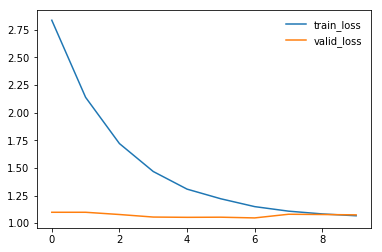

In [18]:
plt.plot(ltrain, label='train_loss')
plt.plot(lvalid, label='valid_loss')
plt.legend(frameon=False)
plt.show()